In [2]:
import numpy as np # scientific computing
import pandas as pd # data loading and processing
import os # os operations
import matplotlib.pyplot as plt # for generating figures
import math
import matplotlib.dates as mdates
import seaborn as sns # for generating visualizations, better support with pandas than matplotlib
from scipy import stats

In [3]:
def get_gene_names(filename,col=None):
    file = pd.read_csv(filename, index_col=None, header= 0).T
    names = file[col].dropna().tolist()
    return names

In [4]:
def construct_filename(c, db):
    if db =="xena":
        n1 = "./data/" + "TCGA." + c + ".sampleMap_HiSeqV2"
        n2 = "./data/" + "TCGA." + c + ".sampleMap_"+ c +"_clinicalMatrix"
    elif db == "cbio":
        n1 = "./data/" + c+"_data_mrna_seq_v2_rsem.txt"
        n2 = "./data/" + c + "_data_clinical_sample.txt"
    else:
        print("db must be either xena or cbio")
    return n1,n2

def construct_hccdb_filename(n):
    n1 = "./data/HCCDB/HCCDB" + n + "_mRNA_level3.txt"
    n2 = "./data/HCCDB/HCCDB" + n  + ".sample.txt"
    return n1,n2

In [5]:
def get_xena_data(n1):
    df = pd.read_csv(n1, index_col = 0, sep = "\t") # gene x patient
    return df

def get_cbio_data(n1):
    df = pd.read_csv(n1, index_col = 0, sep = "\t").drop(["Entrez_Gene_Id"], axis=1) # gene x patient
    return df

def get_hccdb_data(n1):
    df = pd.read_csv(n1, index_col = 1, sep = "\t").drop(["Entrez_ID"], axis=1) # gene x patient
    return df


def get_xena_pheno(n2):
    pheno = pd.read_csv(n2, index_col=0, sep = "\t")
    pheno = pheno[["sample_type"]]
    pheno_filtered = pheno.dropna()
    return pheno_filtered

def get_cbio_pheno(n2):
    pheno = pd.read_csv(n2, index_col=1,header = 4, sep = "\t")
    pheno = pheno[["SAMPLE_TYPE"]]
    pheno_filtered = pheno.dropna()
    return pheno_filtered

def get_hccdb_pheno(n2):
    pheno = pd.read_csv(n2, index_col=0, sep = "\t").T
    pheno = pheno[["TYPE"]]
    pheno_filtered = pheno.dropna()
    return pheno_filtered



In [6]:
def process_data(df, targets, y_var_names, pheno_filtered=None):

    # subset to get relevant genes
    df_filtered = df.loc[targets]
    # print(df_filtered)
    print(df_filtered.isnull().values.any())


    # check for nan values
    na_filter = df_filtered.isnull().any()
    na_ls = na_filter[na_filter == True].index.to_list()
    print(na_ls)
    
    # impute nan values
    mean_ls = df_filtered.mean()
    for na_col in na_ls:
        df_filtered[na_col] = df_filtered[na_col].fillna(mean_ls[na_col])
    print(df_filtered.isnull().values.any())
    df_filtered = df_filtered.T # patients x genes

    # scale numerical data
    df_filtered = np.log10(df_filtered+1)

    # for each sequenced gene were rescaled to set the median equal to 1
    df_filtered=((df_filtered-df_filtered.median())/df_filtered.std())+1

    # add sample type labels
    if pheno_filtered is not None:
        data = pd.concat([df_filtered, pheno_filtered], axis = 1, join='inner')

    # take only nrf2 target genes
    y_var_gene_set = data[y_var_names]
    data.drop(y_var_names, inplace = True, axis = 1)
    y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)
    data = pd.concat([data, y_var_gene_set], axis = 1) # patients x genes 

    return data

def analyse(data, fig, axs, cancer, c, fn, x_target = "RRM2B", y_target = "composite_score"):
    #find line of best fit
    y, x = data[y_target].to_numpy(), data[x_target].to_numpy()
    a, b = np.polyfit(x, y, 1)

    iqr = data[x_target].T.describe()

    # bin the patients into quartiles based on G6PD expression
    data["RRM2B levels"] = pd.cut(data["RRM2B"],
                    bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                    labels=["Bottom 25%", "-", "Top 25%"])

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]

    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2

    # plot the data

    # scatter plot for RRM2B against NRF2 activity
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x=x_target, y=y_target, ax= axs[cancer.index(c)])
    axs[cancer.index(c)].plot(x, a*x+b, color="black")
    axs[cancer.index(c)].set_ylabel("NRF2 activity (based on 53 genes)",fontsize = 18)
    axs[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=10,fontsize = 15)
    axs[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    axs[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    plt.show()

    # save the figure 
    fig.savefig(fn)

In [7]:
def get_targets_present(data, targets):
    idx = data.index.to_list()
    # print(idx)
    # print(targets)
    targets_present = list(set(idx).intersection(set(targets)))
    # print(targets_present)
    return targets_present

True
['TCGA-A6-2671-01', 'TCGA-A6-2672-01', 'TCGA-A6-2674-01', 'TCGA-A6-2676-01', 'TCGA-A6-2677-01', 'TCGA-A6-2678-01', 'TCGA-A6-2679-01', 'TCGA-A6-2680-01', 'TCGA-A6-2681-01', 'TCGA-A6-2683-01', 'TCGA-A6-3807-01', 'TCGA-A6-3808-01', 'TCGA-A6-3809-01', 'TCGA-A6-3810-01', 'TCGA-A6-4107-01', 'TCGA-AA-3488-01', 'TCGA-AA-3494-01', 'TCGA-AA-3510-01', 'TCGA-AA-3514-01', 'TCGA-AA-3517-01', 'TCGA-AA-3518-01', 'TCGA-AA-3519-01', 'TCGA-AA-3520-01', 'TCGA-AA-3521-01', 'TCGA-AA-3522-01', 'TCGA-AA-3524-01', 'TCGA-AA-3525-01', 'TCGA-AA-3527-01', 'TCGA-AA-3529-01', 'TCGA-AA-3530-01', 'TCGA-AA-3531-01', 'TCGA-AA-3532-01', 'TCGA-AA-3534-01', 'TCGA-AA-3538-01', 'TCGA-AA-3542-01', 'TCGA-AA-3543-01', 'TCGA-AA-3544-01', 'TCGA-AA-3548-01', 'TCGA-AA-3549-01', 'TCGA-AA-3552-01', 'TCGA-AA-3553-01', 'TCGA-AA-3555-01', 'TCGA-AA-3560-01', 'TCGA-AA-3561-01', 'TCGA-AA-3664-01', 'TCGA-AA-3666-01', 'TCGA-AA-3667-01', 'TCGA-AA-3673-01', 'TCGA-AA-3678-01', 'TCGA-AA-3679-01', 'TCGA-AA-3680-01', 'TCGA-AA-3681-01', 'TCGA-

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


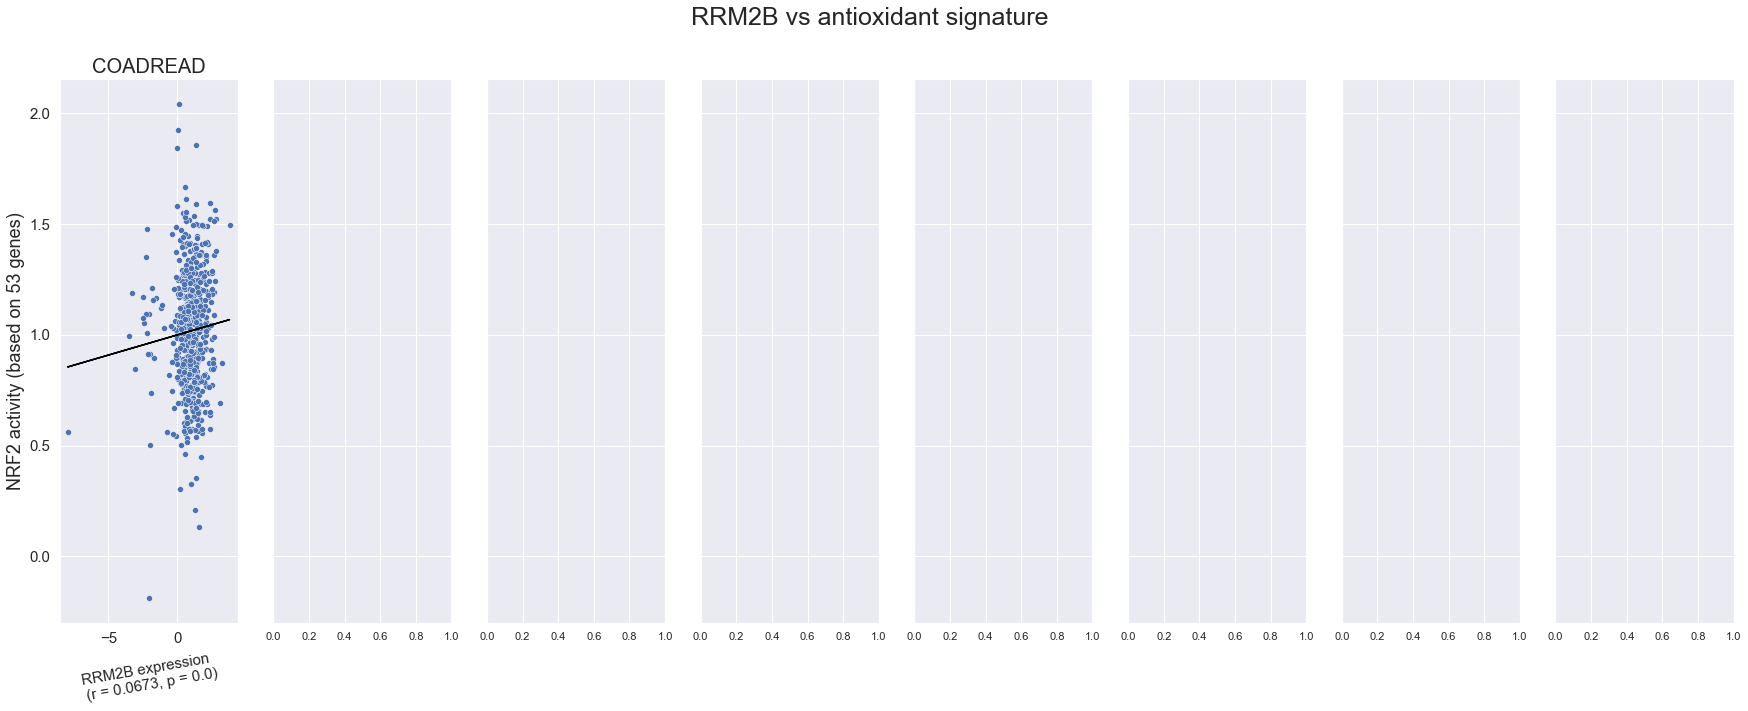

False
[]
False


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


False
[]
False


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


False
[]
False


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


False
[]
False


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


False
[]
False


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


True
['TCGA-04-1348-01', 'TCGA-04-1357-01', 'TCGA-04-1362-01', 'TCGA-04-1364-01', 'TCGA-04-1365-01', 'TCGA-04-1514-01', 'TCGA-04-1519-01', 'TCGA-09-0364-01', 'TCGA-09-0366-01', 'TCGA-09-0367-01', 'TCGA-09-0369-01', 'TCGA-09-1659-01', 'TCGA-09-1662-01', 'TCGA-09-1666-01', 'TCGA-09-1667-01', 'TCGA-09-1668-01', 'TCGA-09-1669-01', 'TCGA-09-1670-01', 'TCGA-09-1673-01', 'TCGA-09-1674-01', 'TCGA-09-2044-01', 'TCGA-09-2045-01', 'TCGA-09-2051-01', 'TCGA-09-2054-01', 'TCGA-10-0928-01', 'TCGA-10-0936-01', 'TCGA-13-0730-01', 'TCGA-13-0799-01', 'TCGA-13-0800-01', 'TCGA-13-0801-01', 'TCGA-13-0890-01', 'TCGA-13-0893-01', 'TCGA-13-0897-01', 'TCGA-13-0899-01', 'TCGA-13-0913-01', 'TCGA-13-0916-01', 'TCGA-13-0920-01', 'TCGA-13-0924-01', 'TCGA-13-1403-01', 'TCGA-13-1405-01', 'TCGA-13-1410-01', 'TCGA-13-1411-01', 'TCGA-13-1481-01', 'TCGA-13-1497-01', 'TCGA-13-1498-01', 'TCGA-13-1505-01', 'TCGA-13-1506-01', 'TCGA-13-1507-01', 'TCGA-13-1511-01', 'TCGA-13-1512-01', 'TCGA-13-2060-01', 'TCGA-13-A5FT-01', 'TCGA-

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


False
[]
False


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


In [10]:
# get names of ox_stress target genes

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
gene_set = gene_set['Review v3'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  gene_set))

rval1 =[]
rval2 = []
cancer = ["COADREAD", "HNSC", "KIRC", "LUAD", "LIHC", "LUSC", "OV", "BRCA"] # , , "PANCAN"

fig, axs = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
fig.suptitle('RRM2B vs antioxidant signature',fontsize = 25)

for c in cancer:
    n1, n2 = construct_filename(c, "cbio")
    df = get_cbio_data(n1)
    pheno_filtered = get_cbio_pheno(n2)
    data = process_data(df, targets, gene_set, pheno_filtered)
    analyse(data, fig, axs, cancer, c, "RRM2B vs antioxidant final.png", x_target = "RRM2B", y_target = "composite_score")


True
['TCGA-A6-2671-01', 'TCGA-A6-2672-01', 'TCGA-A6-2674-01', 'TCGA-A6-2676-01', 'TCGA-A6-2677-01', 'TCGA-A6-2678-01', 'TCGA-A6-2679-01', 'TCGA-A6-2680-01', 'TCGA-A6-2681-01', 'TCGA-A6-2683-01', 'TCGA-A6-3807-01', 'TCGA-A6-3808-01', 'TCGA-A6-3809-01', 'TCGA-A6-3810-01', 'TCGA-A6-4107-01', 'TCGA-AA-3488-01', 'TCGA-AA-3494-01', 'TCGA-AA-3510-01', 'TCGA-AA-3514-01', 'TCGA-AA-3517-01', 'TCGA-AA-3518-01', 'TCGA-AA-3519-01', 'TCGA-AA-3520-01', 'TCGA-AA-3521-01', 'TCGA-AA-3522-01', 'TCGA-AA-3524-01', 'TCGA-AA-3525-01', 'TCGA-AA-3527-01', 'TCGA-AA-3529-01', 'TCGA-AA-3530-01', 'TCGA-AA-3531-01', 'TCGA-AA-3532-01', 'TCGA-AA-3534-01', 'TCGA-AA-3538-01', 'TCGA-AA-3542-01', 'TCGA-AA-3543-01', 'TCGA-AA-3544-01', 'TCGA-AA-3548-01', 'TCGA-AA-3549-01', 'TCGA-AA-3552-01', 'TCGA-AA-3553-01', 'TCGA-AA-3555-01', 'TCGA-AA-3560-01', 'TCGA-AA-3561-01', 'TCGA-AA-3664-01', 'TCGA-AA-3666-01', 'TCGA-AA-3667-01', 'TCGA-AA-3673-01', 'TCGA-AA-3678-01', 'TCGA-AA-3679-01', 'TCGA-AA-3680-01', 'TCGA-AA-3681-01', 'TCGA-

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


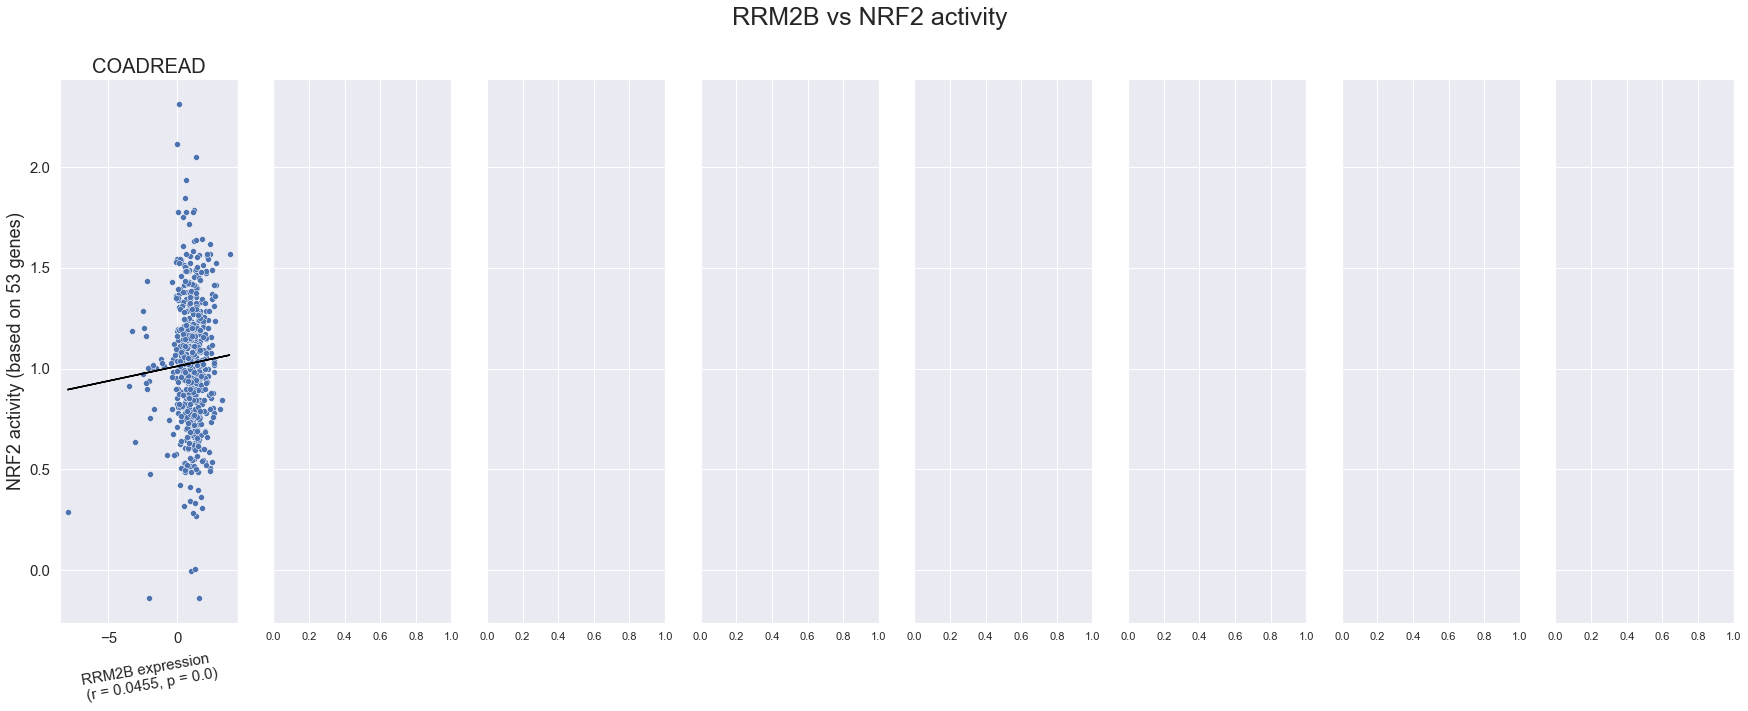

False
[]
False


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


False
[]
False


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


False
[]
False


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


False
[]
False


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


False
[]
False


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


True
['TCGA-04-1348-01', 'TCGA-04-1357-01', 'TCGA-04-1362-01', 'TCGA-04-1364-01', 'TCGA-04-1365-01', 'TCGA-04-1514-01', 'TCGA-04-1519-01', 'TCGA-09-0364-01', 'TCGA-09-0366-01', 'TCGA-09-0367-01', 'TCGA-09-0369-01', 'TCGA-09-1659-01', 'TCGA-09-1662-01', 'TCGA-09-1666-01', 'TCGA-09-1667-01', 'TCGA-09-1668-01', 'TCGA-09-1669-01', 'TCGA-09-1670-01', 'TCGA-09-1673-01', 'TCGA-09-1674-01', 'TCGA-09-2044-01', 'TCGA-09-2045-01', 'TCGA-09-2051-01', 'TCGA-09-2054-01', 'TCGA-10-0928-01', 'TCGA-10-0936-01', 'TCGA-13-0730-01', 'TCGA-13-0799-01', 'TCGA-13-0800-01', 'TCGA-13-0801-01', 'TCGA-13-0890-01', 'TCGA-13-0893-01', 'TCGA-13-0897-01', 'TCGA-13-0899-01', 'TCGA-13-0913-01', 'TCGA-13-0916-01', 'TCGA-13-0920-01', 'TCGA-13-0924-01', 'TCGA-13-1403-01', 'TCGA-13-1405-01', 'TCGA-13-1410-01', 'TCGA-13-1411-01', 'TCGA-13-1481-01', 'TCGA-13-1497-01', 'TCGA-13-1498-01', 'TCGA-13-1505-01', 'TCGA-13-1506-01', 'TCGA-13-1507-01', 'TCGA-13-1511-01', 'TCGA-13-1512-01', 'TCGA-13-2060-01', 'TCGA-13-A5FT-01', 'TCGA-

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


False
[]
False


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_58280/2133945067.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)


In [9]:
# get names of ox_stress target genes

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
gene_set = gene_set['NRF2 v3'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  gene_set))

rval1 =[]
rval2 = []
cancer = ["COADREAD", "HNSC", "KIRC", "LUAD", "LIHC", "LUSC", "OV", "BRCA"] # , , "PANCAN"

fig, axs = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
fig.suptitle('RRM2B vs NRF2 activity',fontsize = 25)

for c in cancer:
    n1, n2 = construct_filename(c, "cbio")
    df = get_cbio_data(n1)
    pheno_filtered = get_cbio_pheno(n2)
    data = process_data(df, targets, gene_set, pheno_filtered)
    analyse(data, fig, axs, cancer, c, "RRM2B vs NRF2 final.png", x_target = "RRM2B", y_target = "composite_score")


In [ ]:
# get names of ox_stress target genes

master_gene_list = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
nrf2_set = master_gene_list['NRF2 v2'].dropna().tolist()
ox_stress_set = master_gene_list['Review v2'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  nrf2_set + ox_stress_set))

db_num = ["1", "3", "4",  "8", "9", "11", "12", "13", "14", "15", "16", "17", "18"]

fig, axs = plt.subplots(1, len(db_num), figsize=(30, 10), sharey=True)
fig.suptitle('[HCCDB] RRM2B vs NRF2',fontsize = 25)

fig1, axs1 = plt.subplots(1, len(db_num), figsize=(30, 10), sharey=True)
fig1.suptitle('[HCCDB] RRM2B vs oxdidative stress',fontsize = 25)

for c in db_num:
    n1, n2 = construct_hccdb_filename(c)
    df = get_hccdb_data(n1)
    # print(df)
    pheno_filtered = get_hccdb_pheno(n2)
    targets_new = get_targets_present(df, targets)
    nrf2_new = get_targets_present(df, nrf2_set)
    ox_stress_new = get_targets_present(df, ox_stress_set)
    print("PTGR1" in targets_new)
    print("GSTM2" in targets_new)
    print("GSTM2P1" in targets_new)
    data_nrf2 = process_data(df, targets_new, nrf2_new, pheno_filtered)
    data_oxstress = process_data(df, targets_new, ox_stress_new, pheno_filtered)
    analyse(data_nrf2, fig, axs, db_num, c, "RRM2B vs NRF2 v3 hccdb.png", x_target = "RRM2B", y_target = "composite_score")
    analyse(data_oxstress, fig1, axs1, db_num, c, "RRM2B vs ox stress v3 hccdb.png", x_target = "RRM2B", y_target = "composite_score")


In [ ]:
"RRM2B" in ox_stress_new

In [ ]:
ox_stress_new

In [ ]:
df1 = pd.read_csv("./data/HCCDB/HCCDB6_mRNA_level3.txt", index_col=1,  sep = "\t").T # gene x patient
"RRM2B" in df1.columns.to_list()

In [ ]:
"./data/HCCDB/HCCDB" + n + ""